## Setup environment

In [2]:
import os
import time
import glob
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms


import torch


/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


# configuration to segment Allen cell dataset

In [2]:
# configuration to segment Allen cell dataset
from natsort import natsorted

import os

dataset = 'allen'
model_input_ROI = (128,128,32)
infer_ROI = (256,256,32)

model_path ='../../runs/allen_cellpose100_unet_lr2e4_128_128_32_v1/foldNone/model_final.pt'


model_type = 'swin'
a_min = 385
a_max = 481

min_size = 50*50

data_dir = '../allen100/'
output_dir = data_dir +'results_3d_'+ model_type +'_monai_minsize' +str(min_size) 
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
valid_img_full_paths = natsorted(glob.glob(data_dir+'images/*.tiff'))[::5]



# configuration to segment nanolive cell dataset

In [48]:
# configuration to segment nanolive cell dataset
from natsort import natsorted

import os

dataset = 'nanolive'
model_input_ROI = (128,128,32)
# model_input_ROI = (64,64,32)
infer_ROI = (256,256,32)
input_image_reshape_size = (512,512,96) # need to be changed

dsp = 1

fold =1
 
model_type = 'swin'


model_path =f'../../runs/Nanolive_mem_cellpose_swinunetr_{model_input_ROI[0]}_{model_input_ROI[1]}_32_v6_nor_dsp{dsp}_scratch_no_aug/fold1/model_final.pt'

a_min = 1
a_max = 100

min_size = 50*50/dsp/dsp

data_dir ='/data/nanolive/06222023_segmentation/Nanolive_mem_cellpose_data_v5_nor_1_99/'


output_dir = data_dir +f'results_3d_v5_{model_type}_minsize_' +str(round(min_size)) +'_dsp_' +str(dsp)
print(output_dir)
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
valid_img_full_paths = natsorted(glob.glob(data_dir+'images/*.tiff'))[::]
# valid_img_full_paths = natsorted(glob.glob(data_dir+'*.tiff'))[::]
print(len(valid_img_full_paths))
print('output directory',output_dir)

/data/nanolive/06222023_segmentation/Nanolive_mem_cellpose_data_v5_nor_1_99/results_3d_v5_swinunetr_minsize_278_dsp_3
10
output directory /data/nanolive/06222023_segmentation/Nanolive_mem_cellpose_data_v5_nor_1_99/results_3d_v5_swinunetr_minsize_278_dsp_3


# configuration to segment colon

In [3]:
# configuration to segment colon
from natsort import natsorted

import os

dataset = 'colon'
model_input_ROI = (128,128,32)
infer_ROI = (256,256,32)
# infer_ROI = (128,128,32)


model_path = '/home/xzhang/Projects/cellpose/runs/colon_cellpose_swinunetr_128_128_32_v2_1_255_colon_30/foldNone/model_final.pt'

model_type = 'swin'

a_min = 1
a_max = 255
dsp =1

min_size = 50*50
data_dir = '/data/download_data/colon_dataset/colon_30/'
output_dir = data_dir +'prediction_test_volume_v2_1_255_'+ model_type +'_monai_minsize' +str(min_size)  # test volume
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
valid_img_full_paths = natsorted(glob.glob(data_dir+'images/*.tif'))
print(len(valid_img_full_paths))

30


# test inference

In [4]:

from monai import data, transforms

print(len(valid_img_full_paths))

if dataset =='nanolive':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(512//dsp,512//dsp,96//dsp))
elif dataset =='colon':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(1200//dsp,960//dsp,128//dsp))
elif dataset =='allen':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(900//dsp,600//dsp,64//dsp)),
else:
    raise Warning("dataset not defined")
# test_datalist = [{'image':a} for a in img_full_paths[0::10]] 
test_datalist = [{'image':a} for a in valid_img_full_paths] 
print('Number of test images',len(test_datalist))
if dataset =='nanolive':
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transform_resize,
            transforms.ScaleIntensityRanged(
                # keys=["image"], a_min=17000, a_max=29000, b_min=0, b_max=1, clip=True
                keys=["image"], a_min=a_min, a_max=a_max, b_min=0, b_max=1, clip=True
            ),
            transforms.ToTensord(keys=["image"]),
        ]
    )
else:
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            # transforms.Resized(keys=["image"],spatial_size=(512//dsp,512//dsp,96//dsp)),
            transforms.ScaleIntensityRanged(
                # keys=["image"], a_min=17000, a_max=29000, b_min=0, b_max=1, clip=True
                keys=["image"], a_min=a_min, a_max=a_max, b_min=0, b_max=1, clip=True
            ),
            transforms.ToTensord(keys=["image"]),
        ]
    )


test_ds = data.Dataset(data=test_datalist[0::1], transform=test_transform)
# test_loader = data.DataLoader(
#         test_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
#     )
test_loader = data.DataLoader(
        test_ds, batch_size=1, sampler=None, drop_last=True
    )

30
30


In [6]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR, UNet,UNETR
import tifffile
from functools import partial

# model_type = 'unet'
# model_input_ROI = (32,32,32)
if str.lower(model_type) == 'swin':
    model = SwinUNETR(
        img_size=model_input_ROI,
        in_channels=1,
        out_channels=4,
        feature_size=48,
        use_checkpoint=False,
    ).cuda(device)
elif str.lower(model_type) == 'unet':
    model = UNet(

            spatial_dims=3,
            in_channels=1,
            out_channels=4,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),

        ).cuda(device)
else:
    raise Exception("Model not defined") 

model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=infer_ROI,
    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
    mode='gaussian'
    # mode='constant',
)


# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("Total parameters count", pytorch_total_params)


Exception: Model not defined

In [15]:

from cellpose.dynamics import compute_masks

post_sigmoid = Activations(sigmoid=True)

post_pred = AsDiscrete(argmax=False, threshold=0.5)

from skimage import morphology
import numpy as np
import os
def postprocessing(img,threshold =0.5):

    img = np.uint8(img>threshold )[:,:,:]  # need 
    width = 10 
    #--------------2D processing-----------------------
    img1 = np.zeros_like(img,dtype = np.uint8)
    for i in range(img.shape[2]):
        img1[:,:,i] = morphology.remove_small_holes(img[:,:,i], width ** 2)
        img1[:,:,i] = morphology.remove_small_objects(img1[:,:,i], width ** 2)

    #-------------3D processing----------------------
    img2 = morphology.remove_small_holes(img1, width ** 3)
    img2 = morphology.remove_small_objects(img2, width ** 3)

    return img2


with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            out_filename =valid_img_full_paths[idx].split('.')[0].split('/')[-1] +'_pred.tiff' 
            # print(out_filename)
            data_test = batch_data["image"]
            data_test = data_test.cuda(device)
            logits = model_inferer(data_test)
            print(out_filename)
            logits_out =  np.squeeze(logits.detach().cpu().numpy())
            print('logits shape',logits_out.shape)

            # logits_out =np.float32(logits_out)
            logits_out = np.transpose(logits_out,(0,3,2,1))
            # print('cell prob ', logits[0].max(),logits[0].min())
            # logits_out[0] = np.uint8(logits_out[0]>0)
            logits_out[0] = post_pred(post_sigmoid(logits_out[0]))
            # masks_recon,p = compute_masks(logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.0,flow_threshold=0, do_3D=True)
            masks_recon,p = compute_masks(10*logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=min_size, use_gpu=True)
            
            tifffile.imwrite(output_dir +'/logits_'+out_filename ,logits_out)
            tifffile.imwrite(output_dir +'/cellpose_size_'+str(round(min_size))+'_'+out_filename ,masks_recon)

            print(logits.shape, logits.max(),logits.min())



image-final_0000_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(42.7622, device='cuda:1') tensor(-188.8518, device='cuda:1')
image-final_0001_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(41.9800, device='cuda:1') tensor(-189.1288, device='cuda:1')
image-final_0002_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(43.3210, device='cuda:1') tensor(-211.3802, device='cuda:1')
image-final_0003_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(47.5696, device='cuda:1') tensor(-175.1026, device='cuda:1')
image-final_0004_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(43.2555, device='cuda:1') tensor(-186.7797, device='cuda:1')
image-final_0005_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(44.9499, device='cuda:1') tensor(-189.5179, device='cuda:1')
image-fina

# testing different parameters to compute_mask from flows

['/data/download_data/colon_dataset/colon_30/labels/image-labels_0002.tif'] 
 ['/data/download_data/colon_dataset/colon_30/prediction_test_volume_swinunetr_monai_minsize100/logits_image-final_0002_pred.tiff']


Text(0.5, 1.0, 'gt')

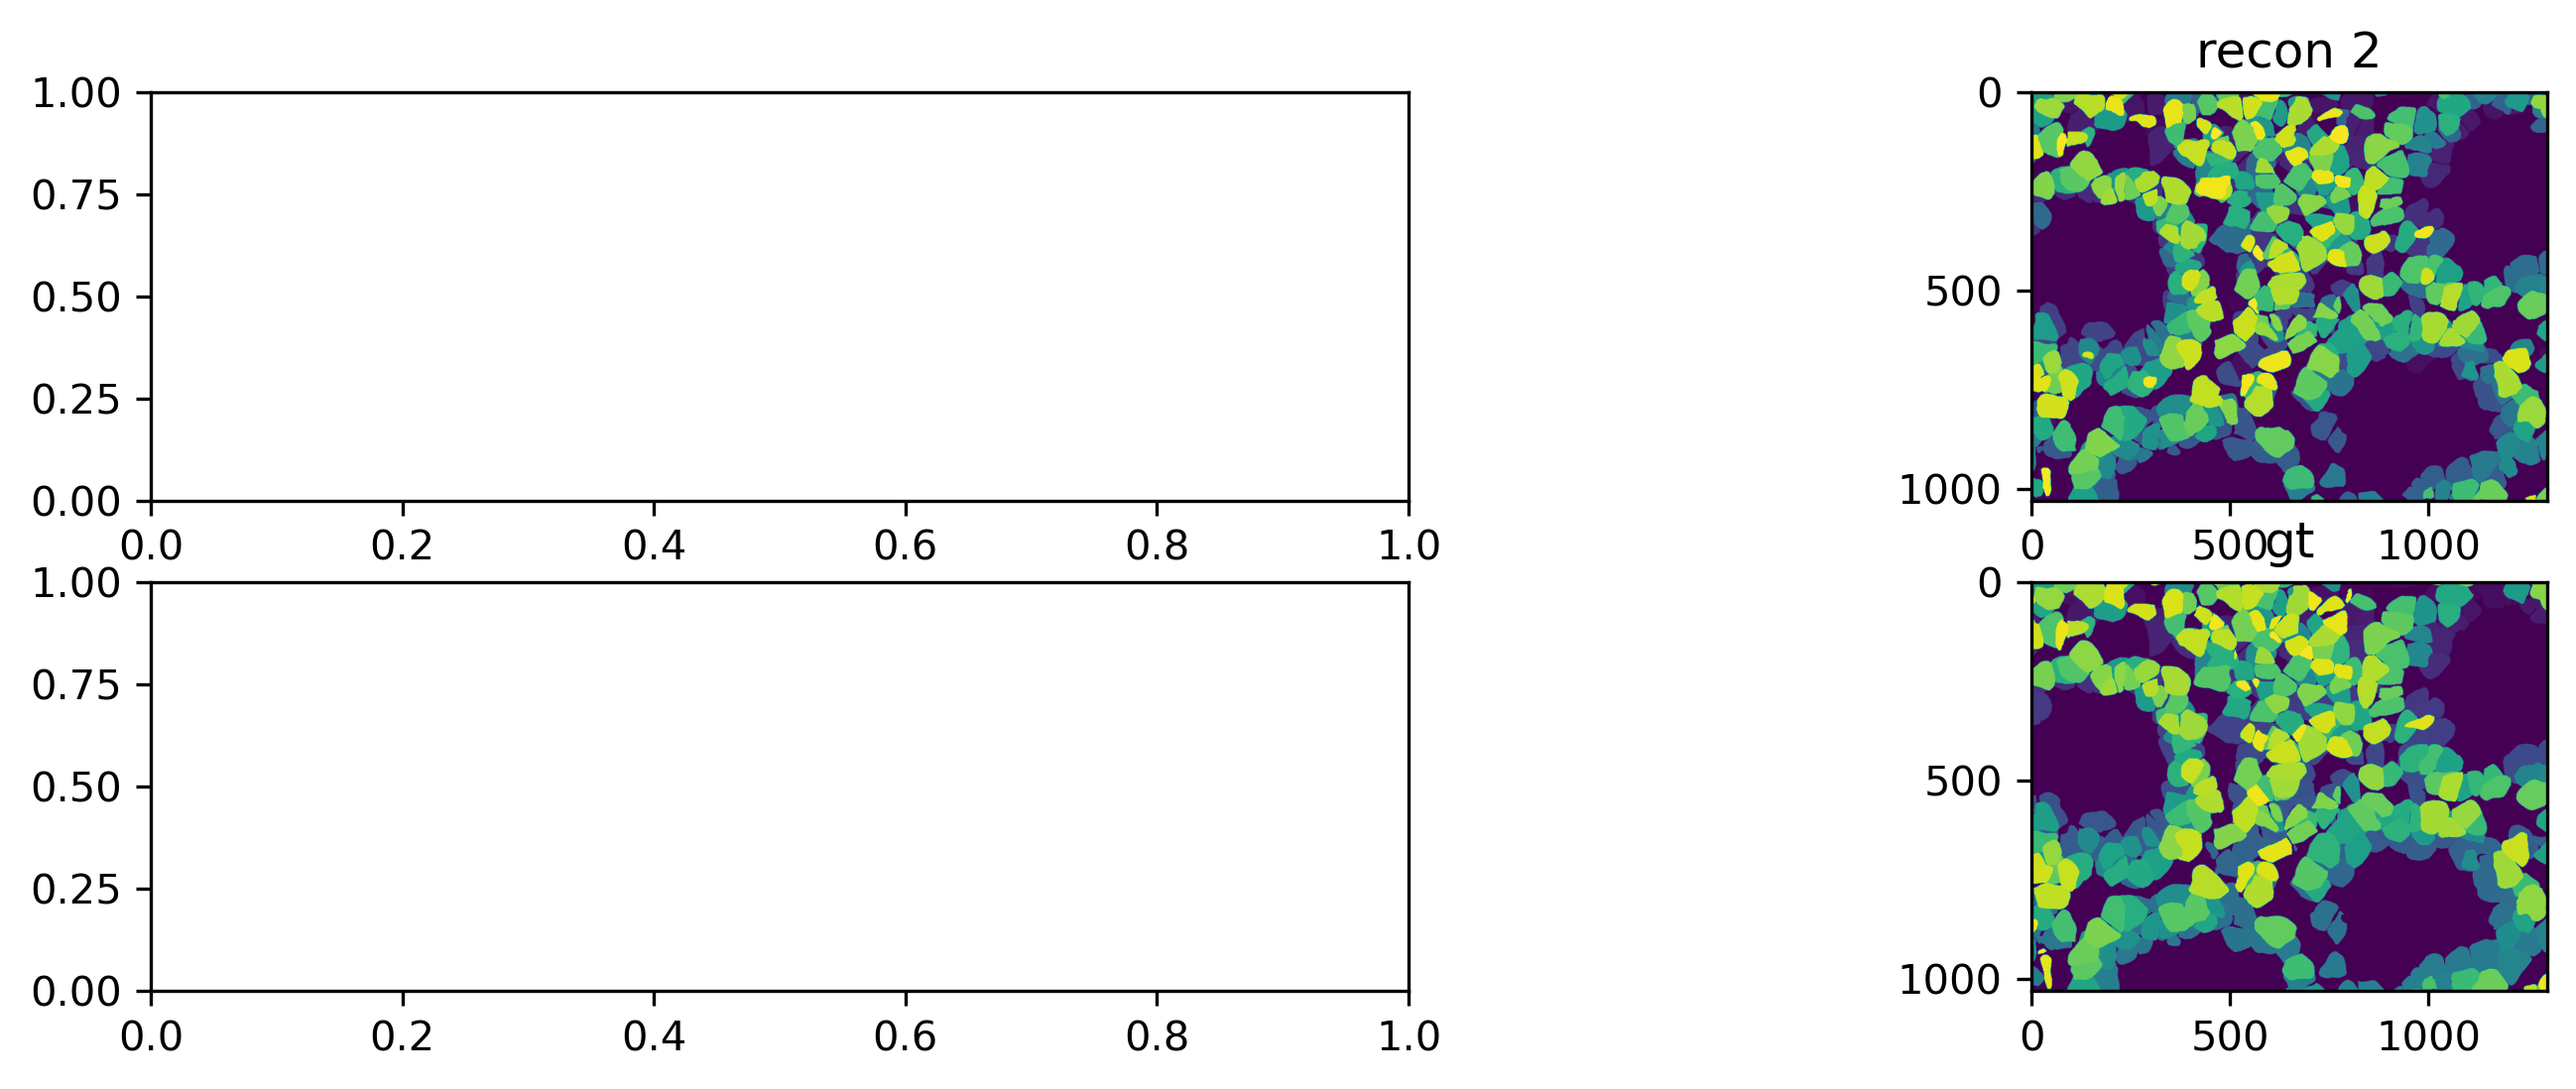

In [5]:
# use the logits computed by previous step, or load presaved flows in tiff format?
from cellpose.dynamics import compute_masks
if 0: #  use previous
    valid_flow = logits_out
else: # load pre saved tiffile 
    dsp = 1
    valid_flow_path = '/data/download_data/colon_dataset/colon_30/prediction_test_volume_swinunetr_monai_minsize100/logits*02*'
    valid_flow_file = glob.glob(valid_flow_path)
    valid_flow = tifffile.imread(valid_flow_file[0])

gt_flow_path = '/data/download_data/colon_dataset/colon_30/labels/*0002*'

print(glob.glob(gt_flow_path),'\n',valid_flow_file)
gt_file = tifffile.imread(glob.glob(gt_flow_path)[0])
from skimage import measure
gt_file =  measure.label(gt_file)



masks_recon2,p = compute_masks(2*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.5,flow_threshold=0.4, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)

# masks_recon3,p = compute_masks(1*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.5,flow_threshold=0.4, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)


# masks_recon_gt,p = compute_masks(5*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.0,flow_threshold=50, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)

# print(masks_recon.shape)
# tifffile.imwrite(output_dir +'/cellpose_size50000_thre05_constant'+out_filename ,masks_recon)
# import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2,figsize=(12,4), dpi=300)
# #initialize matplotlib figure 1*2 subplots
# print(masks_recon1.shape)
# ax[0,0].imshow(np.max(masks_recon1,axis=0))
# ax[0,0].set_title('recon 1')
ax[0,1].imshow(np.max(masks_recon2,axis=0))
# ax[0,1].imshow(masks_recon2[16])

ax[0,1].set_title('recon 2')
# ax[1,1].imshow(masks_recon_gt[20])
ax[1,1].imshow(np.max(gt_file,axis=0))
ax[1,1].set_title('gt')

'/home/xzhang/Projects/cellpose'

In [14]:
from utils.utils import calculate_cell_volumes, plot_box_with_violin
import numpy as np
from scipy import ndimage

def size_filter(mask):
    # Get unique labels excluding the background label (0)
    labels = np.unique(mask)
    labels = labels[labels != 0]

    # Calculate the volume of each cell
    volumes = []
    for label in labels:
        cell_volume = np.sum(mask == label)
        if cell_volume < 40:
            mask[mask==label] = 0

    return mask



import numpy as np
from scipy.ndimage import label, find_objects,binary_closing


def fill_small_holes_3d(mask, threshold):
    # Label connected components (cells)
    labeled_mask, num_features = label(mask)
    
    # Find the unique labels
    unique_labels = np.unique(labeled_mask)[1:]  # Exclude background label 0
    
    # Iterate through each labeled region
    for label_value in unique_labels:
        # Create a binary mask for the current region
        region_mask = labeled_mask == label_value
        
        # Calculate the volume of the current region
        volume = np.sum(region_mask)
        
        # If the volume is less than the threshold, fill the region with the label value
        if volume < threshold:
            mask[region_mask] = label_value
            
    return mask

from scipy.ndimage import find_objects, binary_fill_holes

def fill_small_holes_3d_v2(masks, min_size=1000,bin_closing_structure=np.ones((5,5,3)).astype(int)):

    masks = masks.copy()
    if masks.ndim > 3 or masks.ndim < 2:
        raise ValueError('masks_to_outlines takes 2D or 3D array, not %dD array'%masks.ndim)
    
    slices = find_objects(masks)
    j = 0
    for i,slc in enumerate(slices):
        if slc is not None:
            msk = masks[slc] == (i+1)
            npix = msk.sum()
            if min_size > 0 and npix < min_size:
                masks[slc][msk] = 0
            elif npix > 0:  
                # if bin_closing_structure is not None:
                #     for _ in range(3): # repeat 3 times
                #         msk = binary_closing(msk,bin_closing_structure)


                if msk.ndim==3:
                    for k in range(msk.shape[0]):
                        msk[k] = binary_closing(msk,bin_closing_structure)
                        msk[k] = binary_fill_holes(msk[k])
                        
                
                else:          
                    msk = binary_fill_holes(msk)
                masks[slc][msk] = (j+1)
                j+=1
    return masks
# Example usage:
# Assuming 'mask' is your 3D instance segmentation mask
# Set your desired volume threshold, e.g., threshold = 100
# filled_mask = fill_small_holes_3d(mask, threshold)


# Example usage:
# Assuming 'mask' is your 3D image mask as a numpy array
# cell_diameters = calculate_cell_diameters(mask)




# vol_seg1 = calculate_cell_volumes(masks_recon1)
# masks_recon2
# masks_recon2_post = fill_small_holes_3d(masks_recon2[:,:300,:300],100)
masks_recon2_post1 = fill_small_holes_3d_v2(masks_recon2,200,np.ones((25,25,5)))

# masks_recon2_post2 = fill_small_holes_3d_v2(masks_recon2,5000,np.ones((25,25,5)))


# vol_seg2 = calculate_cell_volumes(masks_recon2)

vol_seg2_post1 = calculate_cell_volumes(masks_recon2_post1)
# vol_seg2_post2 = calculate_cell_volumes(masks_recon2_post2)


# vol_gt = calculate_cell_volumes(gt_file)
# print(vol_seg1,vol_seg2)
# print(len(vol_seg1),len(vol_seg2),len(vol_seg3),len(vol_gt))
# print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3),np.median(vol_gt))


In [25]:
print(masks_recon2.shape)

(129, 1030, 1300)


In [111]:
# print(len(vol_seg1),len(vol_seg2),len(vol_seg3),len(vol_gt))
# print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3),np.median(vol_gt))

# print(np.mean(vol_seg1),np.mean(vol_seg2),np.mean(vol_seg3),np.mean(vol_gt))
# # print(len(vol_seg1),len(vol_seg2),len(vol_seg3))
# # print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3))
# print(gt_file.shape,masks_recon1.shape)

497 507 530 536
51847.0 56993.0 49344.5 64906.0
60587.7323943662 60594.34319526627 56362.47735849056 68651.28171641791
(129, 1030, 1300) (129, 1030, 1300)


In [55]:


def fill_small_holes_3d_test2(mask, threshold,bin_closing_structure=np.ones((5,5,3)).astype(int)):
    mask = mask.copy()
    # Label connected components (cells)
    labeled_mask, num_features = label(mask)
    
    # Find the unique labels
    unique_labels = np.unique(labeled_mask)[1:]  # Exclude background label 0
    
    # Iterate through each labeled region
    for label_value in unique_labels:
        # Create a binary mask for the current region
        msk = labeled_mask == label_value
        
        # Calculate the volume of the current region
        volume = np.sum(msk)
        
        if msk.ndim==3:
                
            for k in range(msk.shape[0]):

                msk[k] = binary_closing(msk[k],np.ones((10,10)))
                msk[k] = binary_fill_holes(msk[k])
            
        else:          
            msk = binary_fill_holes(msk)
        # masks[slc][msk] = (j+1)

        mask[msk] = label_value
            
    return mask


img_test = tifffile.imread('./vol_seg2_post2.tiff')
print(img_test.shape)
# img_test_post = fill_small_holes_3d_test(img_test,200,np.ones((30,30)))
img_test_post2 = fill_small_holes_3d_test2(img_test[:,385:800,650:1250],200,np.ones((10,10)))
# img_test_post2 = fill_small_holes_3d_test2(img_test,200,np.ones((10,10)))
# tifffile.imwrite('./vol_seg2_post1.tiff',np.uint8(img_test_post1))
# img_test_post = fill_small_holes_3d_test(img_test,200,np.ones((15,15)))
print(img_test.shape)
fig,ax = plt.subplots(2,2,figsize=(12,8), dpi=300)
# #initialize matplotlib figure 1*2 subplots
# print(masks_recon1.shape)
ax[0,0].imshow(img_test[96])
ax[0,0].set_title('recon 1')

ax[0,1].imshow(img_test_post[96])
ax[0,1].set_title('recon post')



# img2= img_test[96].copy()
# # print(img2.shape)
# img2_post = binary_closing(img2,np.ones((10,10)))

# ax[1,0].imshow(img_test_post2)
# ax[1,0].set_title('recon 2')

# ax[1,1].imshow(img2_post)
# ax[1,1].set_title('recon post')


for i in range(2):
       for j in range(2):
         ax[j,i].axis('off')
plt.tight_layout()

(129, 1030, 1300)


KeyboardInterrupt: 

In [54]:
tifffile.imwrite('./vol_seg2_post1_post_newalgo.tiff',np.uint8(img_test_post2))

507 502 536
57106.0 56648.0 64906.0
(129, 1030, 1300) (129, 1030, 1300)


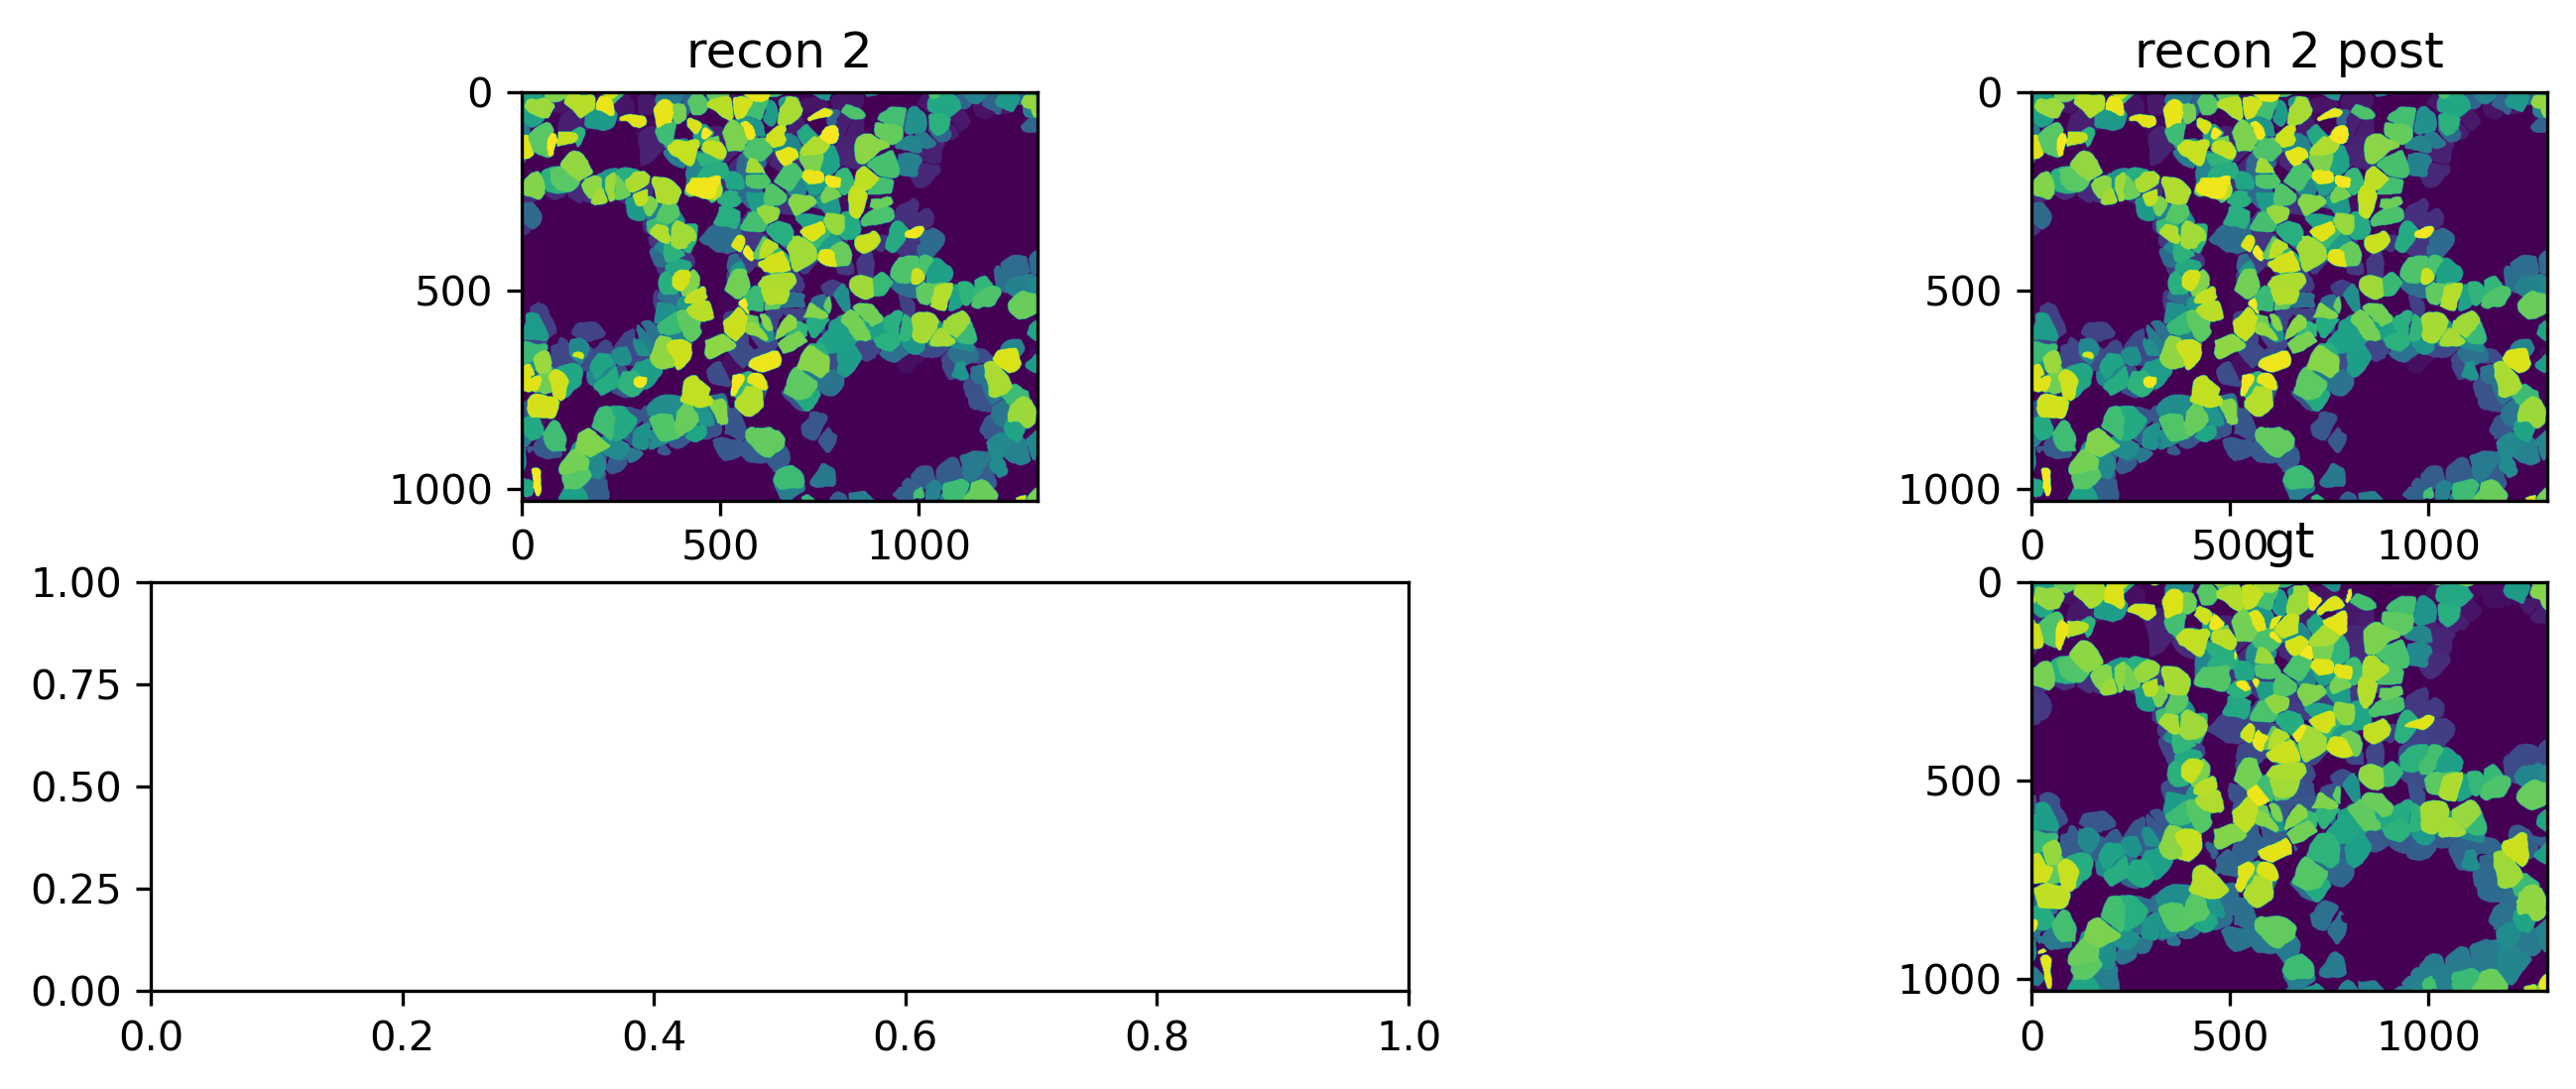

In [17]:

print(len(vol_seg2_post1),len(vol_seg2_post2),len(vol_gt))
print(np.median(vol_seg2_post1),np.median(vol_seg2_post2),np.median(vol_gt))


# print(len(vol_seg1),len(vol_seg2),len(vol_seg3))
# print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3))
print(gt_file.shape,masks_recon2.shape)


fig,ax = plt.subplots(2,2,figsize=(12,4), dpi=300)
# #initialize matplotlib figure 1*2 subplots
# print(masks_recon1.shape)
ax[0,0].imshow(np.max(masks_recon2,axis=0))
ax[0,0].set_title('recon 2')
ax[0,1].imshow(np.max(masks_recon2_post1,axis=0))
ax[0,1].set_title('recon 2 post')
# ax[1,1].imshow(masks_recon_gt[20])
ax[1,1].imshow(np.max(gt_file,axis=0))
ax[1,1].set_title('gt')

tifffile.imwrite('./vol_seg2.tiff',np.uint16(masks_recon2))
tifffile.imwrite('./vol_seg2_post1.tiff',np.uint16(masks_recon2_post1))

In [8]:
import tifffile
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage
file_idx = 1
slice1 = 35
slice2 = 28
side_slice1 = 100
img_raw = tifffile.imread(raw_image_files[file_idx])
img_2d_algo1 = tifffile.imread(results_2d_files_algo1[file_idx])
img_2d_algo2 = tifffile.imread(results_2d_files_algo2[file_idx])  
img_2d_algo1_after_training = tifffile.imread(results_2d_files_algo1_after_training[file_idx])
img_2d_algo2_after_training = tifffile.imread(results_2d_files_algo2_after_training[file_idx]) 
img_3d = tifffile.imread(results_3d_files[file_idx]) 
print(img_3d.shape)

fig,ax = plt.subplots(3,6,figsize=(12,5), dpi=300)

ax[0,0].imshow(img_raw[slice1],cmap='gray')
ax[0,0].set_title('Raw image')
ax[0,1].imshow(img_2d_algo1[slice1])
ax[0,1].set_title('2D V1')
ax[0,2].imshow(img_2d_algo1_after_training[slice1])
ax[0,2].set_title('2D V1, finetuned')

ax[0,3].imshow(img_2d_algo2[slice1])
ax[0,3].set_title('2D V2')
ax[0,4].imshow(img_2d_algo2_after_training[slice1])
ax[0,4].set_title('2D V2, finetuned')
ax[0,5].imshow(img_3d[slice1])
ax[0,5].set_title('Swincell')



ax[1,0].imshow(img_raw[slice2],cmap='gray')
ax[1,1].imshow(img_2d_algo1[slice2])
ax[1,2].imshow(img_2d_algo1_after_training[slice2])

ax[1,3].imshow(img_2d_algo2[slice2])
ax[1,4].imshow(img_2d_algo2_after_training[slice2])
ax[1,5].imshow(img_3d[slice2])

# 
ax[2,0].imshow(ndimage.zoom(img_raw[:,side_slice1],(5,1)),cmap='gray')
ax[2,1].imshow(ndimage.zoom(img_2d_algo1[:,side_slice1],(5,1)))
ax[2,2].imshow(ndimage.zoom(img_2d_algo1_after_training[:,side_slice1],(5,1)))

ax[2,3].imshow(ndimage.zoom(img_2d_algo2[:,side_slice1],(5,1)))
ax[2,4].imshow(ndimage.zoom(img_2d_algo2_after_training[:,side_slice1],(5,1)))
ax[2,5].imshow(ndimage.zoom(img_3d[:,side_slice1],(5,1)))

for i in range(6):
       for j in range(3):
         ax[j,i].axis('off')
plt.tight_layout()


NameError: name 'raw_image_files' is not defined

## Cleanup data directory



In [73]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()